In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})
import trimesh as tr
import pyrender as pr
import colorcet as cc

In [5]:
import src

ModuleNotFoundError: No module named 'src'

# load data

In [4]:
from src.pyushichka import loadCalibration, loadImageUndistorted
ushichka_dir = "/home/julian/Downloads/2018-08-17/"
cam = 1 # 2nd camera
imK, imP = loadCalibration(cam, ushichka_dir)
imIm = loadImageUndistorted(cam, 0, ushichka_dir)

print(f"intrinsics\n{imK}\npinhole projection matrix\n{imP}\n")
plt.figure()
plt.imshow(imIm)
plt.show()

from src.dmcpworkflow.capture_depth import generate_depth_map
mesh_path = "/home/julian/code/uni/ushichka-registration/data/formatted/lidar_roi.ply"
ovMesh = pr.Mesh.from_trimesh(tr.load_mesh(mesh_path))
pvMesh = pv.read(mesh_path)

ModuleNotFoundError: No module named 'src'

# DMCP Workflow

## Generate Depth Map

In [13]:
print("generating depth map")
view_width = 1920
view_height = 1080

view_K = imK.copy()
#view_K[0,-1] = view_width /2
#view_K[1,-1] = view_width / 2

dmimIm, dmIm, dmK, dmP = generate_depth_map(ovMesh,view_K,znear=0.00001,zfar=100,return_img=True)

generating depth map
[[      0.41      -0.03      -0.91       2.06]
 [      0.91       0.04       0.41      -0.15]
 [      0.02      -1.00       0.04       0.09]]
[[      0.41       0.03       0.91]
 [      0.91      -0.04      -0.41]
 [      0.02       1.00      -0.04]]
[[      2.06]
 [     -0.15]
 [      0.09]]


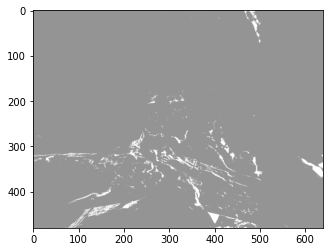

<class 'numpy.ndarray'>


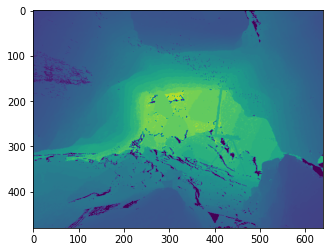

In [14]:
plt.figure()
plt.imshow(dmimIm)
plt.show()

print(type(dmIm))

plt.figure()
plt.imshow(dmIm)
plt.show()

## Annotate Points

In [15]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("TKAgg")
cps = annotate(imIm, dmIm)
%matplotlib inline

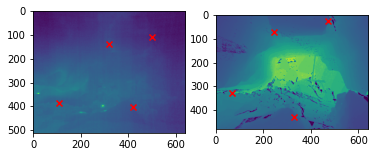

In [16]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r",marker="x")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r",marker="x")
plt.show()

## project to world

In [17]:
from src.pycv.dmcp import dm_to_world

pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])
pts_world

array([[     -5.45,      -0.38,      -0.65],
       [     -0.70,       2.19,       1.86],
       [     -2.37,       1.04,       1.92],
       [     -1.31,       1.46,      -1.00]], dtype=float32)

In [18]:
# visualize cps in world coordinates

pvPts = pv.PolyData(pts_world)

pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)

pl.show()

## dmcp step

In [19]:
from src.pycv.dmcp import dmcp

raw_pose, trans = dmcp(imK, imP, cps[:,:2], pts_world,return_raw_pose=True)
print(f"transformation\n{trans}")

estimated pose
[[      0.51      -0.29      -0.81       2.12]
 [      0.86       0.18       0.48      -1.55]
 [      0.01      -0.94       0.34      -1.33]]
scale factor 0.19646079031611327
transformation
[[     -0.13       0.05      -0.13       1.53]
 [     -0.14      -0.10       0.10      -0.92]
 [      0.04      -0.16      -0.11      -0.99]
 [      0.00       0.00       0.00       1.00]]


In [20]:
print("estiated position")
P_est = imP @ la.inv(trans)
pose_est = la.null_space(P_est) / la.null_space(P_est)[-1]



position_est = pose_est[:3].flatten()
print(position_est)

estiated position
[      2.26      -1.54      -1.38]


ESTIMATED POSE SEEMS TO BE CORRECT BUT TRANSFORMATIOON FAILES

==> Scaling?!?

In [21]:
sv_pos_raw = pv.Sphere(radius=0.25, center=raw_pose[:3,-1])
sv_pos_est = pv.Sphere(radius=0.25, center=position_est)
pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)
pl.add_mesh(sv_pos_est, color="yellowgreen")
pl.add_mesh(sv_pos_raw, color="green")

pl.show()